# OLD VERSION

retained because it's got a useful visualization at the bottom. The proposed solution is not great.

In [9]:
import numpy as np
from pysm3.models import Model, CMBLensed

In [10]:
ps_c1 = "demo_powerspectra/c1_ps.dat"
ps_c1_with_l01 = "demo_powerspectra/c1_ps_l01.dat"

delensing_ells_c1 = "demo_powerspectra/c1_delensing_ells.dat"

# Problem

Running CMBLensed with `apply_delens=False` (default) works as expected.

In [11]:
CMBLensed(nside=128, cmb_spectra=ps_c1, delensing_ells=delensing_ells_c1, apply_delens=False)

Running CMBLensed with `apply_delens=True` causes a ValueError.

In [12]:
try:
    CMBLensed(nside=128, cmb_spectra=ps_c1, delensing_ells=delensing_ells_c1, apply_delens=True)
except ValueError as e:
    print(e)

operands could not be broadcast together with shapes (2199,) (2,) 


# Diagnosing

The delensing ells are transposed. Note that in the following output, the long axis goes from 0 to 1.

In [13]:
a = CMBLensed(nside=128, cmb_spectra=ps_c1, delensing_ells=delensing_ells_c1, apply_delens=False)
a.cmb_spectra.shape, a.delensing_ells.shape

((8, 2199), (2199, 2))

Changing the way the delensing ells are read (adding `unpack=True`) aligns the matrices as the code expects.

In [14]:
class SurrogateCMBLensed(Model):
    def __init__(self, ps_file, apply_delens, nside=2048):
        super().__init__(nside=nside)
        self.nside = nside
        self.cmb_seed = 8675309
        self.cmb_spectra = self.read_txt(ps_file, unpack=True)
        self.apply_delens = apply_delens
        self.delensing_ells = self.read_txt(delensing_ells_c1, unpack=True)  # The fix is here!
        self._map = None

Now the axes line up.

In [15]:
b = SurrogateCMBLensed(ps_c1, True, nside=128)
b.cmb_spectra.shape, b.delensing_ells.shape

((8, 2199), (2, 2199))

And the code runs.

In [16]:
b.run_taylens = CMBLensed.run_taylens  # Patch in the method
b._map = b.run_taylens(b)  # 4.5 minutes at nside=2048; 1 second at nside=128

# Modified run_taylens()

I think I need to account for the presence or absence of L=0 and L=1, following Issue 212.

For display:

In [ ]:
import matplotlib.pyplot as plt

def compare_tebp(tebps, labels, show_lmax=10):
    tebp_idcs = ["TT", "EE", "BB", "PP", "TE", "EB", "BP", "TB", "EP", "TP"]

    for i in range(10):
        if i in [2, 5, 6, 7]:
            continue
        plt.figure()
        for j, tebp in enumerate(tebps):
            plt.plot(tebp[i][:show_lmax], label=labels[j], 
                    #  linewidth=(3-j), 
                     marker=str(j+1), markersize=10)
        plt.title(f"idx {i}, {tebp_idcs[i]}")
        plt.legend()
        plt.show()

In [17]:
def orig_method(self):
    synlmax = 8 * self.nside  # this used to be user-defined.
    data = self.cmb_spectra
    lmax_cl = len(data[0]) + 1

    ell = np.arange(int(lmax_cl + 1))
    synlmax = min(synlmax, ell[-1])

    # Reading input spectra in CAMB format. CAMB outputs l(l+1)/2pi hence the corrections.
    cl_tebp_arr = np.zeros([10, lmax_cl + 1])
    cl_tebp_arr[0, 2:] = 2 * np.pi * data[1] / (ell[2:] * (ell[2:] + 1))  # TT
    cl_tebp_arr[1, 2:] = 2 * np.pi * data[2] / (ell[2:] * (ell[2:] + 1))  # EE
    cl_tebp_arr[2, 2:] = 2 * np.pi * data[3] / (ell[2:] * (ell[2:] + 1))  # BB
    cl_tebp_arr[4, 2:] = 2 * np.pi * data[4] / (ell[2:] * (ell[2:] + 1))  # TE
    cl_tebp_arr[5, :] = np.zeros(lmax_cl + 1)  # EB
    cl_tebp_arr[7, :] = np.zeros(lmax_cl + 1)  # TB

    if self.apply_delens:
        cl_tebp_arr[3, 2:] = (
            2
            * np.pi
            * data[5]
            * self.delensing_ells[1]
            / (ell[2:] * (ell[2:] + 1)) ** 2
        )  # PP
        cl_tebp_arr[6, :] = np.zeros(lmax_cl + 1)  # BP
        cl_tebp_arr[8, 2:] = (
            2
            * np.pi
            * data[7]
            * np.sqrt(self.delensing_ells[1])
            / (ell[2:] * (ell[2:] + 1)) ** 1.5
        )  # EP
        cl_tebp_arr[9, 2:] = (
            2
            * np.pi
            * data[6]
            * np.sqrt(self.delensing_ells[1])
            / (ell[2:] * (ell[2:] + 1)) ** 1.5
        )  # TP
    else:
        cl_tebp_arr[3, 2:] = (
            2 * np.pi * data[5] / (ell[2:] * (ell[2:] + 1)) ** 2
        )  # PP
        cl_tebp_arr[6, :] = np.zeros(lmax_cl + 1)  # BP
        cl_tebp_arr[8, 2:] = (
            2 * np.pi * data[7] / (ell[2:] * (ell[2:] + 1)) ** 1.5
        )  # EP
        cl_tebp_arr[9, 2:] = (
            2 * np.pi * data[6] / (ell[2:] * (ell[2:] + 1)) ** 1.5
        )  # TP

    ###############################
    return cl_tebp_arr

In [18]:
def build_tebp_dl2cl_scale(tebp_shape):
    use_lmax = tebp_shape[1] - 1
    ell = np.arange(use_lmax + 1)
    ell[0] = 1            # Avoid division by zero errors
                          #   This would only affect L=0,
                          #   which will be set to 0.

    scale = np.zeros([10, use_lmax + 1])
    scale[0] = 2 * np.pi / (ell * (ell + 1))         # TT
    scale[1] = 2 * np.pi / (ell * (ell + 1))         # EE
    scale[2] = 2 * np.pi / (ell * (ell + 1))         # BB
    scale[3] = 2 * np.pi / (ell * (ell + 1)) ** 2    # PP
    scale[4] = 2 * np.pi / (ell * (ell + 1))         # TE
    scale[5] = 2 * np.pi / (ell * (ell + 1))         # EB
    scale[6] = 2 * np.pi / (ell * (ell + 1))         # BP
    scale[7] = 2 * np.pi / (ell * (ell + 1))         # TB
    scale[8] = 2 * np.pi / (ell * (ell + 1)) ** 1.5  # EP
    scale[9] = 2 * np.pi / (ell * (ell + 1)) ** 1.5  # TP

    return scale

def rewritten_method(self):
    """
    Assumptions:
    - Multipoles are in order, non-repeating, continuous
    - CAMB output is L, TT, EE, BB, TE, PP, TP, EP
    Old:
    - Multipoles start at 2
    New:
    - Multipoles start at either 0 or 2
    """
    src_dl = self.cmb_spectra
    src_lmax = int(src_dl[0][-1])  # Last value in the first column (L)

    if self.apply_delens and self.delensing_ells[0][-1] < src_lmax:
            # Multipoles are not enough for use_lmax
            raise ValueError(f"Not enough delensing multipoles in file. Need" \
                             f" at least {src_lmax}, have {self.delensing_ells[0][-1]}.")

    if src_dl[0][0] == 2:
        # Multipoles start at 2 (old assumption)
        # Insert zeros and clip to use_lmax
        temp_ps = np.zeros((len(src_dl), src_lmax + 1))
        temp_ps[:, 2:] = src_dl[:, :src_lmax + 1]
        dl = temp_ps
    else:
        # Multipoles start at 0
        # Clip to use_lmax
        dl = src_dl[:, :src_lmax + 1]

    cl_tebp_arr = np.zeros([10, src_lmax + 1])
    cl_tebp_arr[0] = dl[1]  # TT
    cl_tebp_arr[1] = dl[2]  # EE
    cl_tebp_arr[2] = dl[3]  # BB
    cl_tebp_arr[3] = dl[5]  # PP
    cl_tebp_arr[4] = dl[4]  # TE
    cl_tebp_arr[5] = 0      # EB
    cl_tebp_arr[6] = 0      # BP
    cl_tebp_arr[7] = 0      # TB
    cl_tebp_arr[8] = dl[7]  # EP
    cl_tebp_arr[9] = dl[6]  # TP

    scale = build_tebp_dl2cl_scale(cl_tebp_arr.shape)
    cl_tebp_arr *= scale

    if self.apply_delens:
        if self.delensing_ells[0][0] == 2:
            # Multipoles start at 2 (old assumption)
            # Insert zeros and clip to use_lmax
            delensing_ells = np.zeros(src_lmax + 1)
            # Instead of arithmetic, this is more readable
            # Which index has the maximum ell?
            end_idx = np.searchsorted(self.delensing_ells[0], src_lmax)
            delensing_ells[2:] = self.delensing_ells[1][:end_idx + 1]
        else:
            # Multipoles start at 0
            # Clip to src_lmax
            delensing_ells = self.delensing_ells[1][:src_lmax + 1]

        cl_tebp_arr[3] = cl_tebp_arr[3] *         delensing_ells
        cl_tebp_arr[8] = cl_tebp_arr[8] * np.sqrt(delensing_ells)
        cl_tebp_arr[9] = cl_tebp_arr[9] * np.sqrt(delensing_ells)

    # Set values to zero, as the remaining code was tested in this condition
    cl_tebp_arr[:, 0:2] = 0

    return cl_tebp_arr

In [19]:
def cl2dl_tebp(tebp):
    scale = build_tebp_dl2cl_scale(tebp.shape)
    return tebp / scale

In [25]:
tebp_orig_wout_l01 = orig_method(SurrogateCMBLensed(ps_c1, apply_delens=True))
tebp_orig_wout_l01_dl = cl2dl_tebp(tebp_orig_wout_l01)

try:
    tebp_orig_with_l01 = orig_method(SurrogateCMBLensed(ps_c1_with_l01, apply_delens=True))
    tebp_orig_with_l01_dl = cl2dl_tebp(tebp_orig_with_l01)
except ValueError as e:
    print("Error for Original method with l01:", e)

tebp_rewr_wout_l01 = rewritten_method(SurrogateCMBLensed(ps_c1, apply_delens=True))
tebp_rewr_wout_l01_dl = cl2dl_tebp(tebp_rewr_wout_l01)

tebp_rewr_with_l01 = rewritten_method(SurrogateCMBLensed(ps_c1_with_l01, apply_delens=True))
tebp_rewr_with_l01_dl = cl2dl_tebp(tebp_rewr_with_l01)

Error for Original method with l01: operands could not be broadcast together with shapes (2201,) (2199,) 


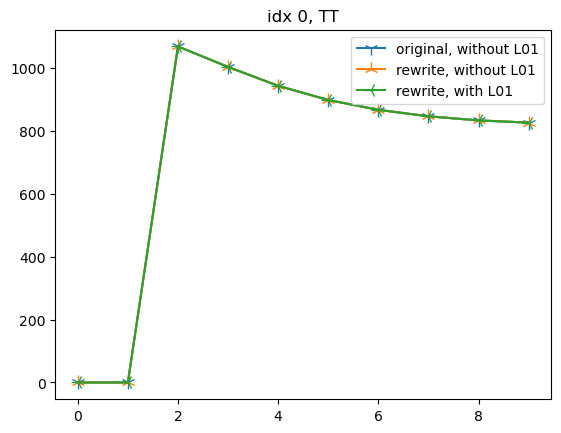

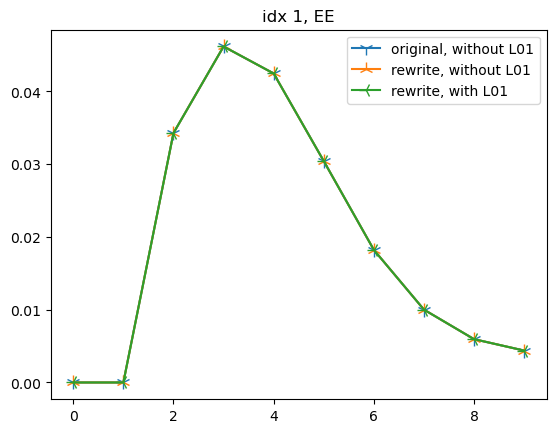

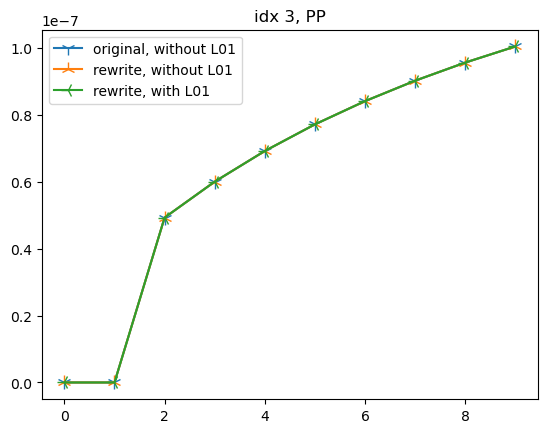

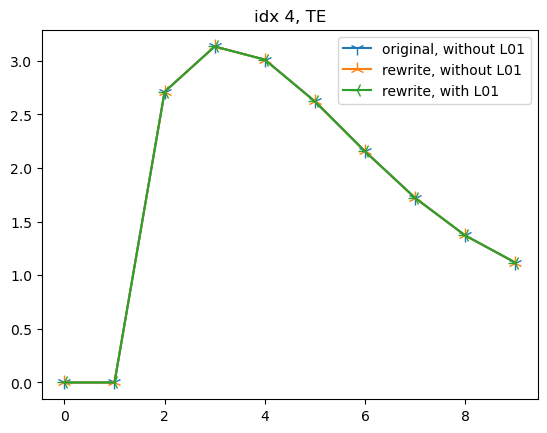

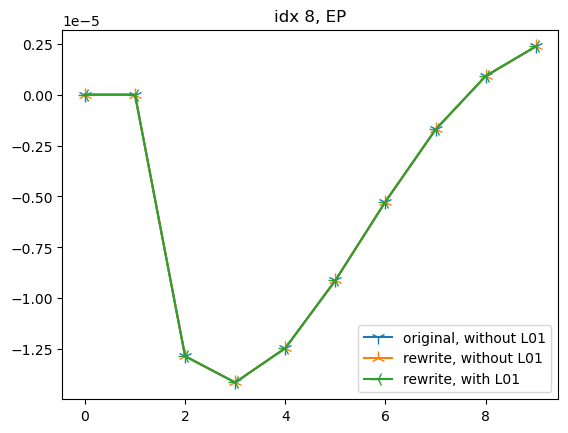

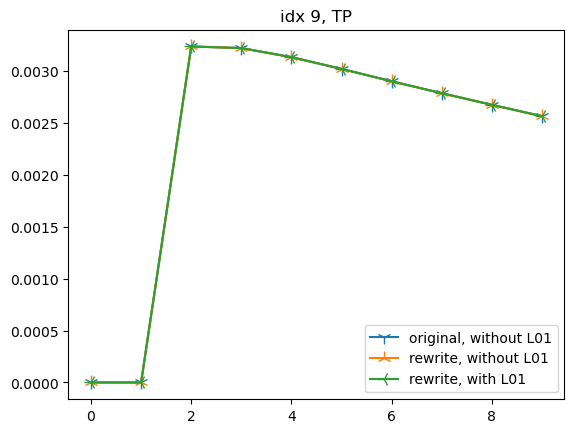

In [28]:
compare_tebp([
              tebp_orig_wout_l01_dl,
              tebp_rewr_wout_l01_dl,
              tebp_rewr_with_l01_dl
              ], 
              [
              "original, without L01",
              "rewrite, without L01",
              "rewrite, with L01"
              ], 10)

Change a value in the delensing ells to confirm that it has the same impact regardless of which method was used...

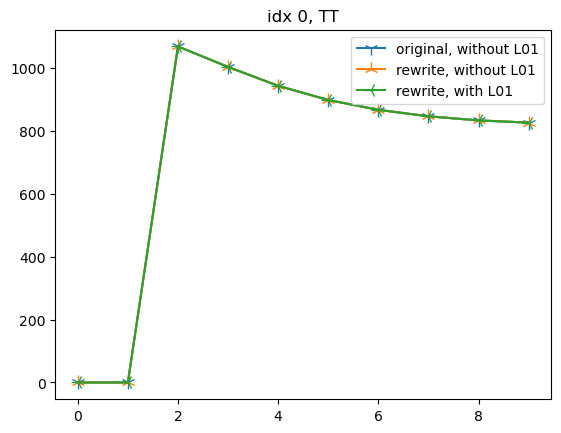

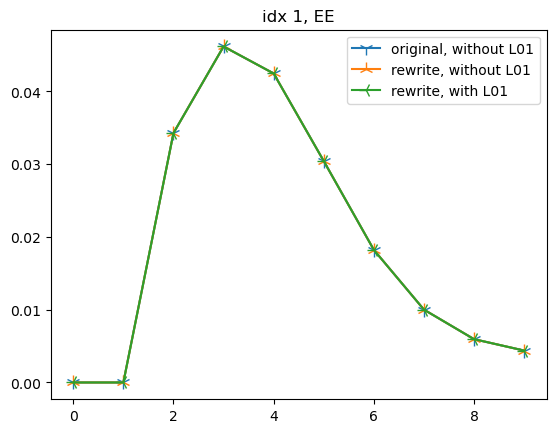

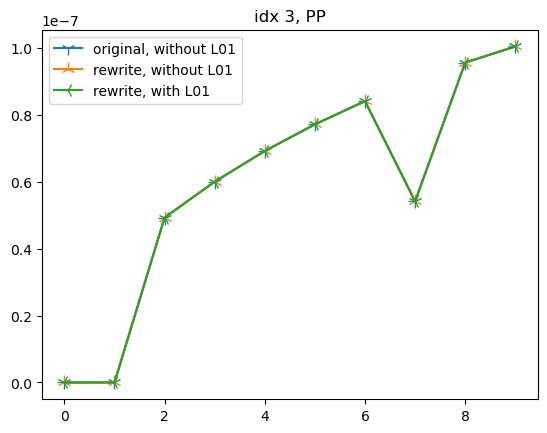

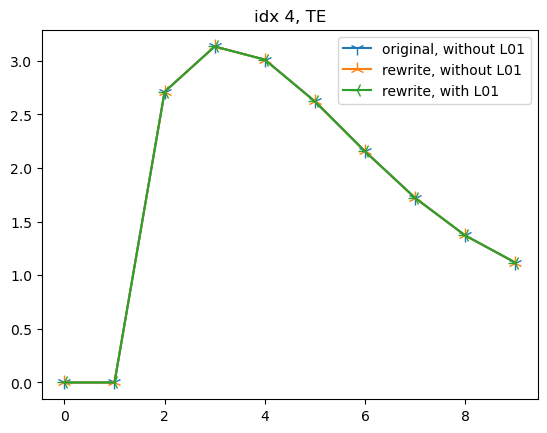

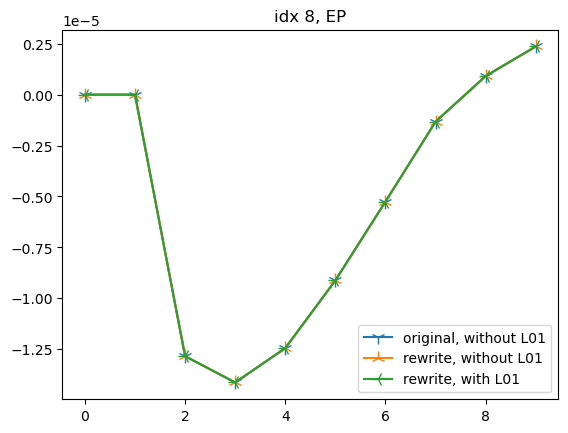

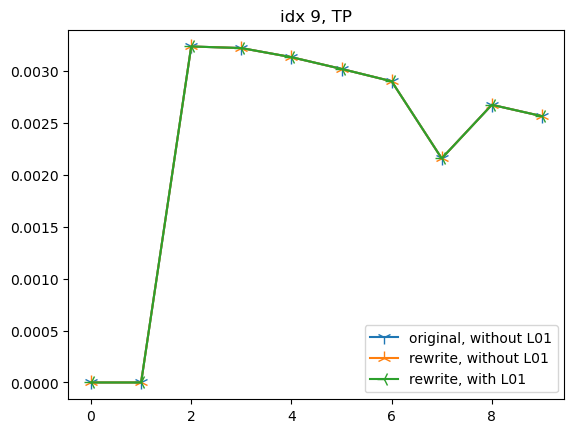

In [39]:
surr_wout_l01 = SurrogateCMBLensed(ps_c1, apply_delens=True)
surr_wout_l01.delensing_ells[1, 5] = 0.6
tebp_orig_wout_l01 = orig_method(surr_wout_l01)
tebp_orig_wout_l01_dl = cl2dl_tebp(tebp_orig_wout_l01)

tebp_rewr_wout_l01 = rewritten_method(surr_wout_l01)
tebp_rewr_wout_l01_dl = cl2dl_tebp(tebp_rewr_wout_l01)

surr_with_l01 = SurrogateCMBLensed(ps_c1_with_l01, apply_delens=True)
surr_with_l01.delensing_ells[1, 5] = 0.6
tebp_rewr_with_l01 = rewritten_method(surr_with_l01)
tebp_rewr_with_l01_dl = cl2dl_tebp(tebp_rewr_with_l01)

compare_tebp([
              tebp_orig_wout_l01_dl,
              tebp_rewr_wout_l01_dl,
              tebp_rewr_with_l01_dl
              ], 
              [
              "original, without L01",
              "rewrite, without L01",
              "rewrite, with L01"
              ], 10)

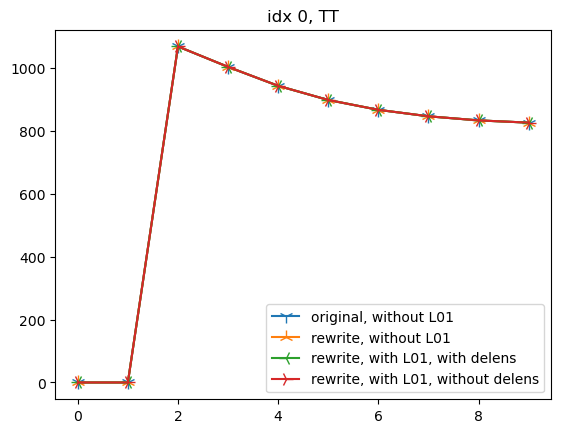

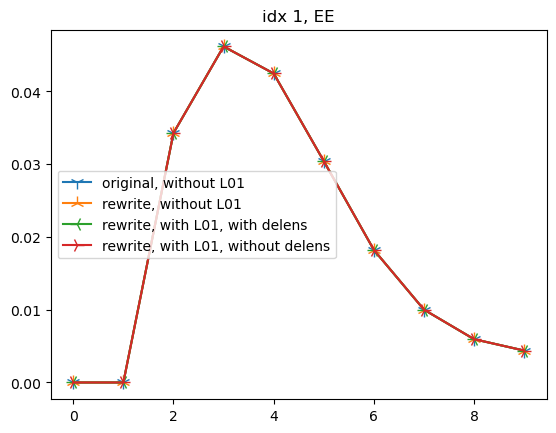

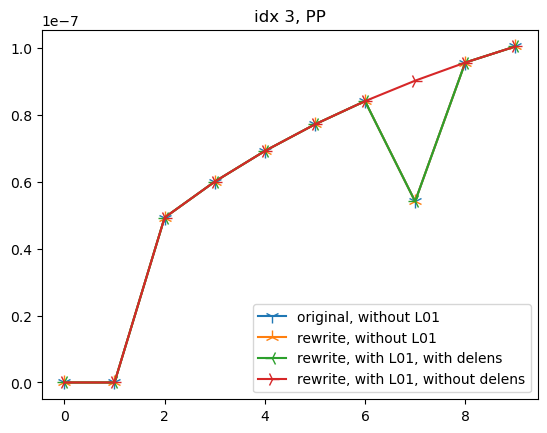

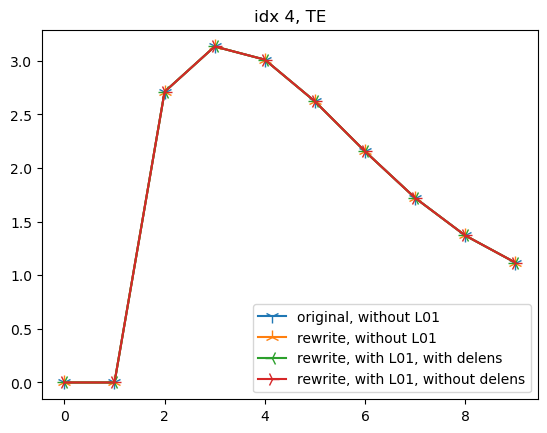

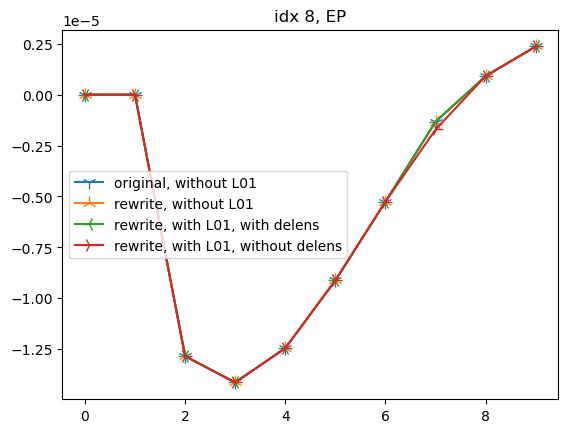

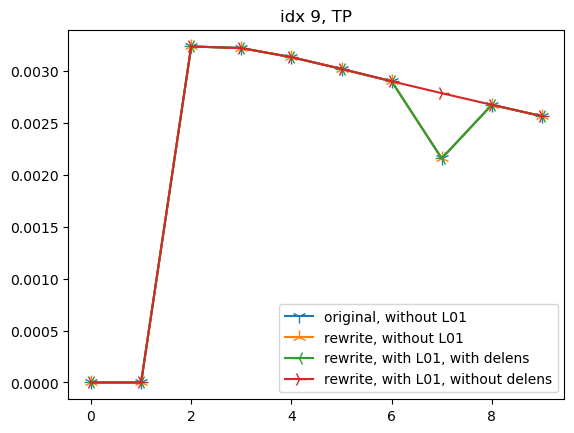

In [38]:
surr_wout_l01 = SurrogateCMBLensed(ps_c1, apply_delens=True)
surr_wout_l01.delensing_ells[1, 5] = 0.6
tebp_orig_wout_l01 = orig_method(surr_wout_l01)
tebp_orig_wout_l01_dl = cl2dl_tebp(tebp_orig_wout_l01)

tebp_rewr_wout_l01 = rewritten_method(surr_wout_l01)
tebp_rewr_wout_l01_dl = cl2dl_tebp(tebp_rewr_wout_l01)

surr_with_l01_with_delens = SurrogateCMBLensed(ps_c1_with_l01, apply_delens=True)
surr_with_l01_with_delens.delensing_ells[1, 5] = 0.6
tebp_rewr_with_l01_with_delens = rewritten_method(surr_with_l01_with_delens)
tebp_rewr_with_l01_dl_with_delens = cl2dl_tebp(tebp_rewr_with_l01_with_delens)

surr_with_l01_wout_delens = SurrogateCMBLensed(ps_c1_with_l01, apply_delens=False)
surr_with_l01_wout_delens.delensing_ells[1, 5] = 0.6
tebp_rewr_with_l01_wout_delens = rewritten_method(surr_with_l01_wout_delens)
tebp_rewr_with_l01_dl_wout_delens = cl2dl_tebp(tebp_rewr_with_l01_wout_delens)

compare_tebp([
              tebp_orig_wout_l01_dl,
              tebp_rewr_wout_l01_dl,
              tebp_rewr_with_l01_dl_with_delens,
              tebp_rewr_with_l01_dl_wout_delens
              ], 
              [
              "original, without L01",
              "rewrite, without L01",
              "rewrite, with L01, with delens",
              "rewrite, with L01, without delens"
              ], 10)